In [29]:
import torch
import torchvision
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np
from torch import nn

trans = transforms.Compose([transforms.ToTensor()])
data_set = torchvision.datasets.MNIST(root='./data', train=True, transform=trans, download=True)
validation_data, training_data, validation_labels, training_labels = \
    train_test_split(data_set.data, data_set.targets, train_size=1 / 6)
print(validation_data.size(), training_data.size())


def split_cells(pic, k_cells):
    n_slices = np.sqrt(k_cells)
    assert int(n_slices + 0.5) ** 2 == k_cells
    n_slices = n_slices.astype(np.int)
    [w, h] = 28, 28
    r = np.linspace(0, w, n_slices + 1)
    r_tuples = [(np.int(r[i]), np.int(r[i + 1])) for i in range(0, len(r) - 1)]
    q = np.linspace(0, h, n_slices + 1)
    q_tuples = [(np.int(q[i]), np.int(q[i + 1])) for i in range(0, len(q) - 1)]
    cell = []
    for row in range(n_slices):
        for column in range(n_slices):
            [x1, y1, x2, y2] = *r_tuples[row], *q_tuples[column]
            cell.append(pic[x1:y1, x2:y2])
    return cell

def positions(array):
  x, y = [], []
  for row in range(len(array[0])):
    for column in range(row):
      if array[row][column] != 0:
        x.append(row)
        y.append(column)
      else:
        x.append(0)
        y.append(0)
  return  np.array(x).reshape(-1,1), np.array(y).reshape(-1,1)

def feature_extract(image):
    density = torch.count_nonzero(image)
    image = split_cells(image, 16)
    features = []
    for i in range(16):
        feature1 = torch.count_nonzero(image[i]) / density
        x, y = positions(image[i])
        model = LinearRegression()
        model.fit(x, y)
        b = model.coef_[0][0]
        feature2 = 2 * b / (1 + b ** 2)
        feature3 = (1 - b ** 2) / (1 + b ** 2)
        features.append(feature1.item())
        features.append(feature2)
        features.append(feature3)
    return torch.Tensor(features)

torch.Size([10000, 28, 28]) torch.Size([50000, 28, 28])


In [30]:
features_training = []
for j in range(len(training_data)):
    features_training.append(feature_extract(training_data[j]))

features_validation = []
for n in range(len(validation_data)):
    features_validation.append(feature_extract(validation_data[n]))


model = nn.Sequential(nn.Linear(48, 50), nn.ReLU(), nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 10))


In [31]:
training_loader = []
for elt in range(len(features_training)):
    training_loader.append((features_training[elt], training_labels[elt].item()))

validation_loader = []
for elt in range(len(features_validation)):
    validation_loader.append((features_validation[elt], validation_labels[elt].item()))

training_loader = torch.utils.data.DataLoader(training_loader, batch_size=16)
validation_loader = torch.utils.data.DataLoader(validation_loader, batch_size=16)

In [32]:
loss_function = nn.CrossEntropyLoss()
optimisation = torch.optim.SGD(model.parameters(), lr=0.001)

In [33]:
epoch = 100

In [42]:
# boucle d'apprentissage:
for ep in range(epoch):
    
    train_loss = 0
    
    for data in training_loader:
        inputs, label = data
        
        output = model(torch.flatten(inputs, start_dim=1))
        
        loss = loss_function(output, label)
        
        optimisation.zero_grad()
        loss.backward()
        
        optimisation.step()
        
        train_loss +=  loss.item() #it's a tensor
    
    train_loss /= len(training_loader)
        

    # boucle de validation:
    valid_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():

        for data in validation_loader:
            inputs, label = data

            output = model(inputs)

            loss = loss_function(output, label)
            valid_loss +=  loss.item()

            correct += torch.sum(torch.argmax(output, dim=1) == label).item()

        valid_loss /= len(validation_loader)
        correct /= len(validation_loader.dataset) #10.000

    print(f"epoch: {ep}, train loss: {train_loss:.4f}, validation loss: {valid_loss:.4f}, correct predictions: {correct*100:.2f}%")

epoch: 0, train loss: 0.5092, validation loss: 0.5217, correct predictions: 83.78%
epoch: 1, train loss: 0.5069, validation loss: 0.5195, correct predictions: 83.85%
epoch: 2, train loss: 0.5047, validation loss: 0.5174, correct predictions: 83.94%
epoch: 3, train loss: 0.5025, validation loss: 0.5153, correct predictions: 83.99%
epoch: 4, train loss: 0.5004, validation loss: 0.5133, correct predictions: 84.05%
epoch: 5, train loss: 0.4983, validation loss: 0.5113, correct predictions: 84.07%
epoch: 6, train loss: 0.4962, validation loss: 0.5092, correct predictions: 84.12%
epoch: 7, train loss: 0.4942, validation loss: 0.5073, correct predictions: 84.14%
epoch: 8, train loss: 0.4922, validation loss: 0.5055, correct predictions: 84.28%
epoch: 9, train loss: 0.4902, validation loss: 0.5037, correct predictions: 84.30%
epoch: 10, train loss: 0.4883, validation loss: 0.5019, correct predictions: 84.31%
epoch: 11, train loss: 0.4865, validation loss: 0.5001, correct predictions: 84.40%
ep

In [47]:
torch.save(model,'modelsave')

In [48]:
def image_read(img):        
        image = cv2.imread(cv2.samples.findFile(img))


        
        dimention = (28,28)
        
        image = cv2.resize(image,dimention,interpolation = cv2.INTER_AREA)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)




        
        plt.imshow(image)
        
        plt.show()


        
        image = torch.Tensor(image)
        
        image = feature_extract(image)
        
        pred = model(image)
        
        print('lapred',torch.argmax(pred))
        
        print(image.shape)

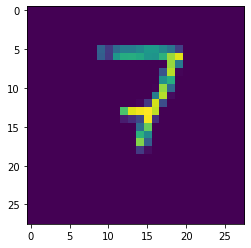

lapred tensor(3)
torch.Size([48])


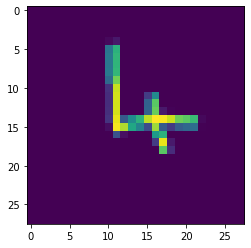

lapred tensor(4)
torch.Size([48])


In [49]:
import cv2
import numpy as np
drawing = False

def draw(event, x, y, flags, param):
  global drawing

  if event == cv2.EVENT_LBUTTONDOWN:
    drawing = True
  elif event == cv2.EVENT_LBUTTONUP:
    drawing = False
  elif event == cv2.EVENT_MOUSEMOVE:
    if drawing == True:
      cv2.circle(img1, (x,y), 10, (255,0,0), -1)

img1 = np.zeros((512,512,1),np.uint8)
cv2.namedWindow("image")
cv2.setMouseCallback("image",draw)
import matplotlib.pyplot as plt
while(1):
    cv2.imshow("image",img1)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('s'):
        break
    elif k == ord('p'):
        cv2.imwrite('resized.png', img1)
        image_read('resized.png')
        
    elif k == ord('c'):
        img1 = np.zeros((512,512,1), np.uint8)
cv2.destroyAllWindows()